### Exercici3
Geolocalitza les IP's.

In [2]:
import pandas as pd
import numpy as np
from ip2geotools.databases.noncommercial import DbIpCity
import time

The code was taken mostly from https://pypi.org/project/ip2geotools/. We will not geolocalize the ips with domain = 'localhost'.

In [3]:
logs = pd.read_csv('webLogs.csv')
logsSlice = logs[~(logs['domain'] == 'localhost')]
ipDb = pd.DataFrame(logsSlice['ip'])

This pieces of code
```python
print(DbIpCity.get(ipDb.iloc[0:,0], api_key = 'free'))
```
```python
aList = list(ipDb.iloc[0:5,0])
DbIpCity.get(aList, api_key = 'free')
```
Throws error, but this one does not:
```python
print(DbIpCity.get(ipDb.iloc[0,0], api_key = 'free'))
```
This may mean that we cannot pass an iterable to the function

In [4]:
def ipChunkToFile(ipList, fileName):
    
    file = open(fileName, 'a', encoding = 'utf-8')
    #For each ip get all the data and write it in a row
    for ip in ipList:
        response = DbIpCity.get(ip, api_key = 'free')
        ip = str(response.ip_address)
        country = str(response.country)
        region = str(response.region)
        city = str(response.city)
        lat = str(response.latitude)
        long = str(response.longitude)
        
        file.write(ip + ';' + country + ';' + region + ';' +
               city + ';' + lat + ';' + long + '\n')
    #If we do not close the file, the file will not be saved
    file.close() 

Iterating through the whole list of ips takes approximately 16hours. To avoid data loss, the list is divided into 16 chunks, and written in a file. This way, if somehow something goes wrong, the data processed until that point, is safe.

In [10]:
#This code is comented so I don't accidentally run it twice, overwriting the file
#Create the file, write the labels of the columns
#f = open('responses.txt', 'w', encoding = 'utf-8')
#f.write('ip;country;region;city;lat;long\n')
#f.close()

(2858, 1)


This is some kind of log of the number of times I had to run the script to collect all the ips.
- Update1: Made it to the 2650th ip. Then lost connection.
- Update2: Exceeded number of requests. Made it to the 5127th ip.
- Update3: Dropped duplicates of ips. Turns out the number of ips is now around 2 thousand, so the file thing is unnecessary
- Update4: Found a unicode char that could not be read. Changed file = open(... enconding = 'utf-8')
- Update5: Exceeded the number of requests. Made it to the 533rd ip. The file strategy is necessary after all.
- Update5: Exceeded the number of requests. Made it to the 1404th ip.
- Update6: Made it to the 2394th ip.Almost there
- Update7: Finished!

In [5]:
uniqueIpDb = ipDb.drop_duplicates()
ips = list(uniqueIpDb.iloc[2394:,0]) #Change the series into a list. Slightly better performance
length = len(ips)
#Get a chunk of the list with ips[i:i+length//16], then pass it to the ipChunkToFile function
for i in range(0, length, length//16):
    
    if (i + length//16) < len(ips):
        ipChunkToFile(ips[i : i + length//16], 'responses.txt')
    #In the case of the last chunk, to avoid out of bounds errors, iterate until the last element
    else:
        ipChunkToFile(ips[i:], 'responses.txt')

Open the file and store it in a dataframe. The pandas function read_csv throws an error when called with the path of the file. If the file is opened and stored as a variable, pandas has no problem in converting it to a DataFrame object.

In [5]:
dataFile = open('responses.txt')

datas = pd.read_csv(dataFile, sep = ';')

datas

,ip,country,region,city,lat,long
0,66.249.76.216,US,California,Mountain View,37.3893889,-122.0832101
1,5.255.253.53,RU,Moscow,Moscow,55.7504461,37.6174943
2,157.55.35.112,CA,Ontario,Toronto,43.6534817,-79.3839347
3,193.111.141.116,NL,North Holland,Amsterdam (Nieuwmarkt en Lastage),None,None
4,5.10.83.71,US,New Jersey,Bridgewater Township,40.596061000000006,-74.6038607920825
...,...,...,...,...,...,...
2853,83.63.131.193,ES,Madrid,Madrid,40.4167047,-3.7035825
2854,46.222.83.180,ES,Catalonia,Sant VicenÃ§ dels Horts,41.3934193,2.0099482
2855,79.155.78.117,ES,Canary Islands,San CristÃ³bal de La Laguna,28.4857715,-16.3159422
2856,188.135.173.80,IT,Lombardy,Desio,45.6183103,9.2081245


We finally have all the IPs geolocalized. Let's check if the dataframe has any unusable value

In [6]:
print(datas.isna().sum())
print(datas[datas['lat'] == 'None'])

ip         0
country    0
region     0
city       0
lat        0
long       0
dtype: int64
                   ip country         region  \
3     193.111.141.116      NL  North Holland   
120     64.71.199.139      US           Iowa   
121     64.71.198.139      US           Iowa   
269    193.111.141.52      NL  North Holland   
288    209.19.189.160      US           Iowa   
310   193.111.141.134      NL  North Holland   
324     209.19.180.69      US           Iowa   
388    193.111.141.44      NL  North Holland   
394     186.28.57.228      CO    Bogota D.C.   
518   189.238.243.227      MX    Mexico City   
621      82.193.99.33      UA      Kyiv City   
732      64.71.201.91      US           Iowa   
835      5.153.20.133      US          Texas   
960     176.102.37.56      UA      Kyiv City   
1117     190.4.66.116      BQ        Bonaire   
1121   190.88.176.120      CW       CuraÃ§ao   
1136    209.19.181.22      US           Iowa   
1213     64.71.199.80      US           Iowa 

There are some locations for which we do not have the latitude and longitude. This may be a problem for the below exercise.

### Exercici 3 (Nivell 3)
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

I am guessing everyone is going with the map visualization. First we should put a counter for each ip to know how may times it appears on the original dataFrame to draw a bubble map

In [7]:
emptyList = [(ipDb['ip'] == ip).sum() for ip in datas['ip']]

datas['count'] = emptyList

In [8]:
datas

,ip,country,region,city,lat,long,count
0,66.249.76.216,US,California,Mountain View,37.3893889,-122.0832101,46382
1,5.255.253.53,RU,Moscow,Moscow,55.7504461,37.6174943,249
2,157.55.35.112,CA,Ontario,Toronto,43.6534817,-79.3839347,131
3,193.111.141.116,NL,North Holland,Amsterdam (Nieuwmarkt en Lastage),None,None,7
4,5.10.83.71,US,New Jersey,Bridgewater Township,40.596061000000006,-74.6038607920825,115
...,...,...,...,...,...,...,...
2853,83.63.131.193,ES,Madrid,Madrid,40.4167047,-3.7035825,126
2854,46.222.83.180,ES,Catalonia,Sant VicenÃ§ dels Horts,41.3934193,2.0099482,103
2855,79.155.78.117,ES,Canary Islands,San CristÃ³bal de La Laguna,28.4857715,-16.3159422,47
2856,188.135.173.80,IT,Lombardy,Desio,45.6183103,9.2081245,2


Since the aim is to draw a bubblemap, locations can be grouped in regions. However, the map needs the latitude and longitude of the place, so a mean of the longitude and latitude can be built to better locate the region. With this procedure, there is also the possibility that the None lat and long can be dealt with.

In [9]:
def countLoc(df):    
    retList = []
    #Check if there is some longitude-latitude information for the region
    if notAllNone(df):
        #If we have some lat long pairs:
        #Get all the rows with no 'None' values
        miniDf = df[~(df['lat'] == 'None') & ~(df['long'] == 'None')]
        nrows = miniDf.shape[0]
        #We want the count for every ip, not only the ones we can locate with long lat pairs
        retList = [pd.to_numeric(miniDf['lat']).sum()/nrows, #Lat and long were stored as strings
                   pd.to_numeric(miniDf['long']).sum()/nrows, 
                   df['count'].sum()] #count was not
        
    else:
        retList = [None, None, df['count'].sum()]
        
    return retList

def notAllNone(df):    
    return (~(df['lat'] == 'None')).sum()

In [42]:
groupeddata = datas.groupby('region')
regionalDict = {}
for region, group in groupeddata:    
    #We may have regions with the same name belonging to different countries
    if len(list(group['country'].unique())) > 1:
        ggroups = group.groupby('country')
        
        for country, ggroup in ggroups:
            regionalDict[region +' '+ country] = countLoc(ggroup)
    else:
        regionalDict[region] = countLoc(group)

This code groups ips by region, stores a mean location for each region and keeps count of the number of queries performed in that region. But we may have some region with no location information, meaning lat = None or long = None for all the different ips belonging to that region. In that case, the code will pass a list with None None as lat long, and the count of the queries.

In [54]:
regLoc = pd.DataFrame.from_dict(regionalDict, orient = 'index', columns = ['lat', 'long', 'count'])
#rename the index axis, then make a column out of it
regLoc = regLoc.rename_axis('region').reset_index()
regLoc.head()

,region,lat,long,count
0,Aargau,47.464343,8.272811,74
1,Abidjan,5.320357,-4.016107,2
2,Aguada,18.379773,-67.188754,81
3,Alabama,32.366966,-86.300648,4
4,Andalusia,37.262093,-5.366973,9560


In [55]:
regLoc[regLoc['lat'].isna()]

,region,lat,long,count
25,Bonaire,NaN,NaN,129
46,CuraÃ§ao,NaN,NaN,21
66,Guangxi,NaN,NaN,7
75,Iowa,NaN,NaN,38
139,QuerÃ©taro,NaN,NaN,1
159,Tennessee,NaN,NaN,40


Since there are few regions with no coordinates, we can manually enter them. Information taken from google.com/maps. 

In [62]:
regLoc.iloc[25] = {'lat' : 12.187937, 'long' : -68.255404}
regLoc.iloc[46] = {'lat' : 12.145983,  'long' : -68.922194}
regLoc.iloc[66] = {'lat' :23.776023,  'long' : 108.894251}
regLoc.iloc[75] = {'lat' : 42.144976, 'long' : -93.963226}
regLoc.iloc[139] = {'lat' : 20.620156, 'long' : -100.412280}
regLoc.iloc[159] = {'lat' : 36.058747, 'long' : -86.189837}
regLoc[regLoc['lat'].isna()]

,region,lat,long,count


Now that we have everything geolocalized with coordinates, we can proceed to draw the map

In [65]:
import cartopy as ctp
import matplotlib
import matplotlib.pyplot as plt

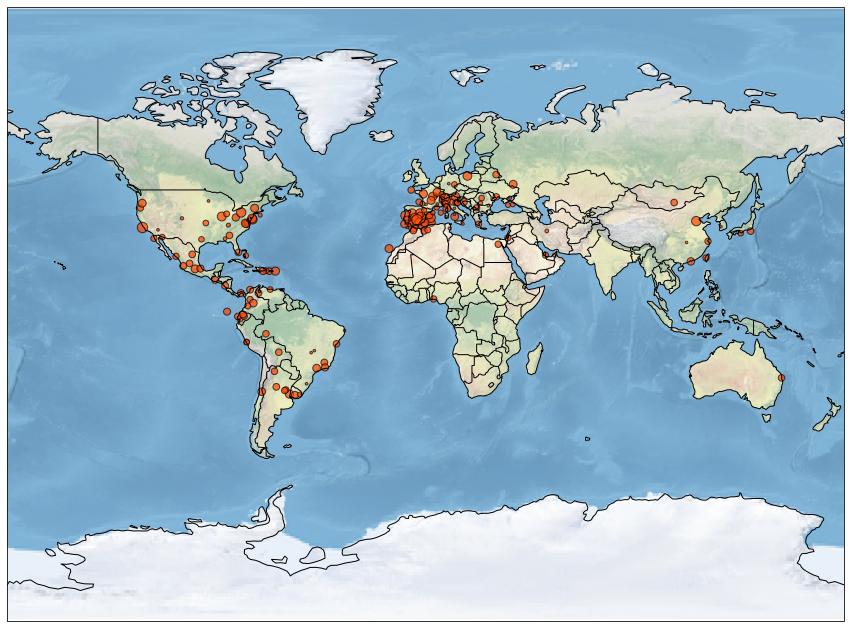

In [103]:
fig = plt.figure(figsize = (15,15))
projection = ctp.crs.Miller()
ax = fig.add_subplot(111, projection = projection)
ax.stock_img()
ax.coastlines()
ax.add_feature(ctp.feature.BORDERS)

ax.scatter(x = regLoc['long'], y = regLoc['lat'],
          color = 'orangered', s = np.log(regLoc['count'])*10,
          alpha = 0.7, transform = projection, linewidth = 1, edgecolors = 'black')
fig.savefig('mapa.png')
plt.show()

It seems we have most of the web wueries from Europe. The next step would be to select all the ips from Europe and plot a zoomed version of the map, to better display the locations.